In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




In [3]:
df = pd.read_csv('online_retail.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [5]:
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

customer ID has lot of missing values (23%) so we need to drop the nulls
A small amount of Description has missing values (0.4%), which is acceptable for aggregated sales analysis


In [6]:
df[['Quantity', 'Price']].describe()

,Quantity,Price
count,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00
std,1.727058e+02,1.235531e+02
min,-8.099500e+04,-5.359436e+04
25%,1.000000e+00,1.250000e+00
50%,3.000000e+00,2.100000e+00
75%,1.000000e+01,4.150000e+00
max,8.099500e+04,3.897000e+04


## Data quallity checks


In [7]:
dups = df.duplicated().sum()
print(f"No of duplicates :{dups}")

print("\n Data Types:")
print((df.dtypes))

empty_rows = df.isnull().all(axis=1).sum()
print(f"\nempty rows: {empty_rows}")

No of duplicates :34335

 Data Types:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

empty rows: 0


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
# coerce : Invalid values are converted to a null value (NaN or NaT),
df['InvoiceDate'].isna().sum()


np.int64(0)

## Data Cleaning & Preparing

In [9]:
#returns/cancellations
#Invoices starting with "C" are treated as cancellations/returns
df_returns = df[df['Invoice'].astype(str).str.startswith('C')].copy()

#main sales data
df_sales = df[~df['Invoice'].astype(str).str.startswith('C')].copy()

len(df), len(df_returns), len(df_sales)

(1067371, 19494, 1047877)

In [10]:
# Keep only positive quantities and prices
df_sales = df_sales[df_sales['Quantity'] > 0]
df_sales = df_sales[df_sales['Price'] > 0]

# Drop missing customers for customer analysis
df_sales = df_sales.dropna(subset=['Customer ID'])

df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


In [11]:
df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['Price']

df_sales['Year'] = df_sales['InvoiceDate'].dt.year
df_sales['Month'] = df_sales['InvoiceDate'].dt.month
df_sales['YearMonth'] = df_sales['InvoiceDate'].dt.to_period('M').astype(str)
df_sales['DayOfWeek'] = df_sales['InvoiceDate'].dt.day_name()
df_sales['Hour'] = df_sales['InvoiceDate'].dt.hour

1. Created a TotalPrice column as Quantity × Price to represent revenue per line item.

2. Extracted Year, Month, YearMonth, DayOfWeek, and Hour from InvoiceDate for time-based analysis.

## Sales Performance Analysis
This section explores overall sales performance over time by analyzing monthly revenue trends. This helps identify seasonality, peak months, and growth patterns.

In [12]:
# Aggregate revenue by month
monthly_revenue = (
    df_sales
    .groupby('YearMonth')['TotalPrice']
    .sum()
    .reset_index()
    .sort_values('YearMonth')
)

monthly_revenue.head()

,YearMonth,TotalPrice
0,2009-12,686654.160
1,2010-01,557319.062
2,2010-02,506371.066
3,2010-03,699608.991
4,2010-04,594609.192


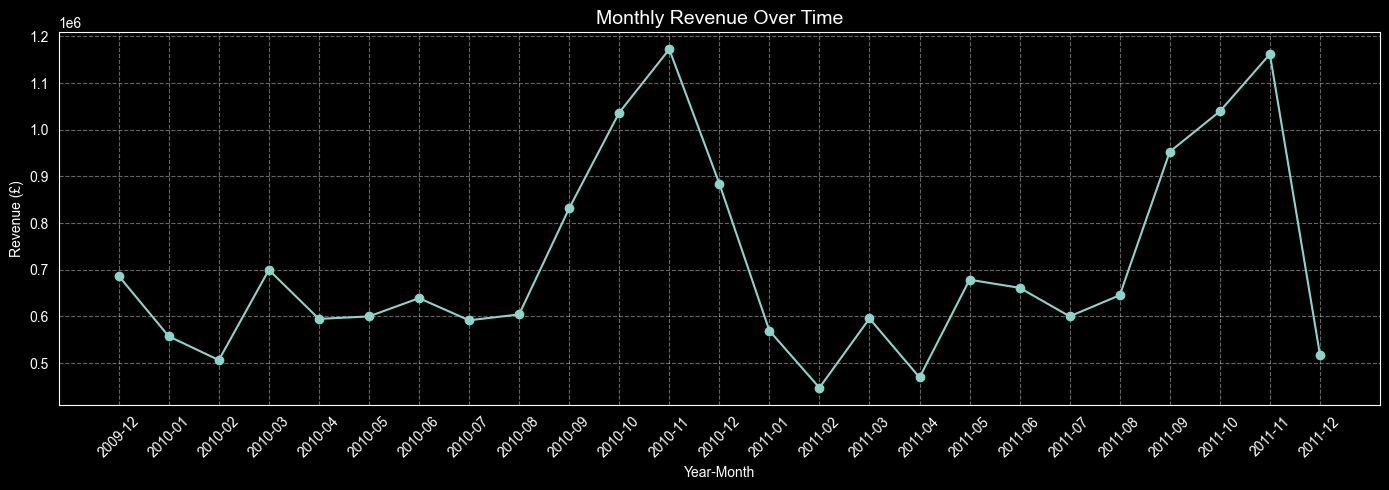

In [13]:
plt.figure(figsize=(14,5))
plt.plot(monthly_revenue['YearMonth'], monthly_revenue['TotalPrice'], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Over Time", fontsize=14)
plt.xlabel("Year-Month")
plt.ylabel("Revenue (£)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Insights:

1. Revenue shows clear seasonality with noticeable peaks, particularly in **September-November** (Q4), indicating strong holiday season demand
2. The business experiences **cyclical patterns** with consistent year-over-year growth trends
3. **Summer months** (June-August) show relatively lower revenue, suggesting seasonal demand fluctuations
4. This seasonality helps identify high-demand periods for inventory planning and marketing campaigns

## Geographic Revenue Distribution

In [14]:
country_revenue = (
    df_sales.groupby('Country')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

country_revenue.head(10)

,Country,TotalPrice
0,United Kingdom,1.472315e+07
1,EIRE,6.216311e+05
2,Netherlands,5.542323e+05
3,Germany,4.312625e+05
4,France,3.552575e+05
5,Australia,1.699681e+05
6,Spain,1.091785e+05
7,Switzerland,1.003653e+05
8,Sweden,9.154972e+04
9,Denmark,6.986219e+04


## Product Performance Analysis

In [15]:
product_revenue = (
    df_sales
    .groupby(['StockCode', 'Description'])['TotalPrice']
    .sum()
    .sort_values(ascending = False)
    .reset_index()
)

product_revenue.head()

,StockCode,Description,TotalPrice
0,22423,REGENCY CAKESTAND 3 TIER,286486.30
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,252072.46
2,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
3,M,Manual,152340.57
4,85099B,JUMBO BAG RED RETROSPOT,136980.08


C:\Users\TULSIRAM\AppData\Local\Temp\ipykernel_3952\407002593.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


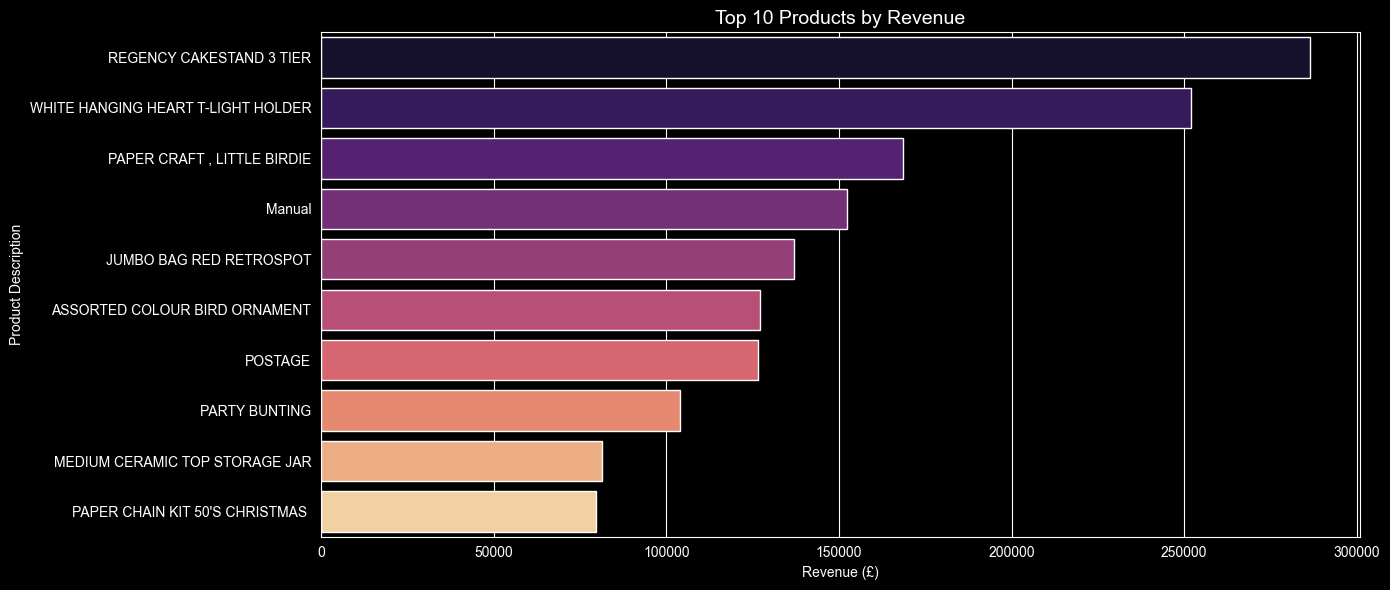

In [16]:
top10_products = product_revenue.head(10)

plt.figure(figsize=(14,6))
sns.barplot(
    data=top10_products,
    x='TotalPrice',
    y='Description',
    palette='magma'
)
plt.title("Top 10 Products by Revenue", fontsize=14)
plt.xlabel("Revenue (£)")
plt.ylabel("Product Description")
plt.tight_layout()
plt.show()

## Insights

1. Top 10 products generate £1.51M, representing 8.5% of total revenue
2. No.1 Product: REGENCY CAKESTAND 3 TIER contributes £286K (1.6% of total revenue)
3. Top 5 products include home décor items: cakestands, hanging heart t-light holders, paper craft supplies, and jumbo bags
4. Product concentration is moderate - top 10 products account for less than 10%, indicating a diversified product portfolio

5. Best sellers are decorative home items and gift products, suggesting strong gifting and home décor market positioning

6. Notable presence of "Manual" in top 5 (£152K) may indicate postage/handling charges or data quality issue requiring investigation


## Customer Segmentation
    (RFM Analysis) - recency, Frequency, Monetary

In [17]:
import datetime as dt

reference_date = df_sales['InvoiceDate'].max() + pd.Timedelta(days =1)

# compute RFM
rfm = (
    df_sales
    .groupby('Customer ID')
    .agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,   # Recency
        'Invoice': 'nunique',                                       # Frequency
        'TotalPrice': 'sum'                                         # Monetary
    })
)

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [40]:
# Define churn based on recency threshold
CHURN_THRESHOLD = 120

rfm['Churn'] = (rfm['Recency'] > CHURN_THRESHOLD).astype(int)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,Churn,Avg_Order_Value,FirstPurchase,LastPurchase,Tenure,Purchase_Intensity,Churn_Probability,Risk_Segment
0,12346.0,326,12,77556.46,1,6463.038333,2009-12-14 08:34:00,2011-01-18 10:01:00,400,0.029925,0.526667,Medium Risk
1,12347.0,2,8,5633.32,0,704.165000,2010-10-31 14:20:00,2011-12-07 15:52:00,402,0.019851,0.190000,Low Risk
2,12348.0,75,5,2019.40,0,403.880000,2010-09-27 14:59:00,2011-09-25 13:13:00,362,0.013774,0.360000,Medium Risk
3,12349.0,19,4,4428.69,0,1107.172500,2010-04-29 13:20:00,2011-11-21 09:51:00,570,0.007005,0.076667,Low Risk
4,12350.0,310,1,334.40,1,334.400000,2011-02-02 16:01:00,2011-02-02 16:01:00,0,1.000000,1.000000,High Risk


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
rfm['Avg_Order_Value'] = rfm['Monetary'] / rfm['Frequency']
X = rfm[['Frequency', 'Monetary', 'Avg_Order_Value']]

y = rfm['Churn']

# Train-test split (stratified because churn is imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression with imbalance handling
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       624
           1       0.63      0.85      0.72       552

    accuracy                           0.70      1176
   macro avg       0.72      0.71      0.70      1176
weighted avg       0.73      0.70      0.69      1176

ROC-AUC: 0.7873612272389445


In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)   # scaling NOT required for trees

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       624
           1       0.61      0.61      0.61       552

    accuracy                           0.63      1176
   macro avg       0.63      0.63      0.63      1176
weighted avg       0.63      0.63      0.63      1176

ROC-AUC: 0.7069935084541061


In [50]:
rfm.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Churn',
       'Avg_Order_Value', 'FirstPurchase_x', 'LastPurchase_x', 'Tenure',
       'Purchase_Intensity', 'Churn_Probability', 'Risk_Segment',
       'FirstPurchase_y', 'LastPurchase_y', 'FirstPurchase', 'LastPurchase'],
      dtype='object')

In [51]:
customer_dates = (
    df_sales
    .groupby('Customer ID')['InvoiceDate']
    .agg(['min', 'max'])
    .reset_index()
)

customer_dates.columns = ['Customer ID', 'FirstPurchase', 'LastPurchase']


In [48]:
rfm.columns


Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Churn',
       'Avg_Order_Value', 'FirstPurchase_x', 'LastPurchase_x', 'Tenure',
       'Purchase_Intensity', 'Churn_Probability', 'Risk_Segment',
       'FirstPurchase_y', 'LastPurchase_y'],
      dtype='object')

In [54]:
# rfm = rfm.merge(customer_dates, on='Customer ID', how='left')
#
# # Tenure in days
# rfm['Tenure'] = (rfm['LastPurchase'] - rfm['FirstPurchase']).dt.days

rfm['Tenure'] = (rfm['LastPurchase'] - rfm['FirstPurchase']).dt.days
rfm['Tenure'] = rfm['Tenure'].fillna(0)



In [55]:
rfm['Tenure'] = (rfm['LastPurchase'] - rfm['FirstPurchase']).dt.days
rfm['Tenure'] = rfm['Tenure'].fillna(0)


In [56]:
rfm['Avg_Order_Value'] = rfm['Monetary'] / rfm['Frequency']
rfm['Purchase_Intensity'] = rfm['Frequency'] / (rfm['Tenure'] + 1)


In [57]:
X = rfm[['Frequency', 'Monetary', 'Avg_Order_Value', 'Purchase_Intensity']]
y = rfm['Churn']


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.75      0.67      0.71       624
           1       0.67      0.76      0.71       552

    accuracy                           0.71      1176
   macro avg       0.71      0.71      0.71      1176
weighted avg       0.71      0.71      0.71      1176

ROC-AUC: 0.7872886473429952


In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))


              precision    recall  f1-score   support

           0       0.69      0.75      0.72       624
           1       0.68      0.62      0.65       552

    accuracy                           0.69      1176
   macro avg       0.69      0.68      0.68      1176
weighted avg       0.69      0.69      0.68      1176

ROC-AUC: 0.7658819328316611


In [60]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance


,Feature,Importance
1,Monetary,0.330008
2,Avg_Order_Value,0.263477
3,Purchase_Intensity,0.243695
0,Frequency,0.162821


In [61]:
rfm['Churn_Probability'] = rf.predict_proba(X)[:, 1]

# Risk segmentation
rfm['Risk_Segment'] = pd.cut(
    rfm['Churn_Probability'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

rfm[['Recency', 'Frequency', 'Monetary', 'Churn_Probability', 'Risk_Segment']].head()


,Recency,Frequency,Monetary,Churn_Probability,Risk_Segment
0,326,12,77556.46,0.500000,Medium Risk
1,2,8,5633.32,0.206667,Low Risk
2,75,5,2019.40,0.390000,Medium Risk
3,19,4,4428.69,0.143333,Low Risk
4,310,1,334.40,0.996667,High Risk


## SMOTE vs Class Weights

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = rfm[['Frequency', 'Monetary', 'Avg_Order_Value', 'Purchase_Intensity']]
y = rfm['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE ONLY on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)

y_pred = lr_smote.predict(X_test_scaled)
y_prob = lr_smote.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression + SMOTE")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Logistic Regression + SMOTE
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       624
           1       0.67      0.76      0.71       552

    accuracy                           0.71      1176
   macro avg       0.71      0.71      0.71      1176
weighted avg       0.72      0.71      0.71      1176

ROC-AUC: 0.7869315542549239


experimented with both SMOTE-based oversampling and class-weighted learning. Since both produced similar ROC-AUC and recall, I chose class-weighted Logistic Regression for simplicity and stability

In [63]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost Results")
print(classification_report(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, xgb_prob))


XGBoost Results
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       624
           1       0.68      0.78      0.73       552

    accuracy                           0.73      1176
   macro avg       0.73      0.73      0.73      1176
weighted avg       0.73      0.73      0.73      1176

ROC-AUC: 0.8088405216462281


In [64]:
import pandas as pd

xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

xgb_importance


,Feature,Importance
0,Frequency,0.578088
3,Purchase_Intensity,0.191072
1,Monetary,0.139814
2,Avg_Order_Value,0.091027


In [66]:
import joblib

joblib.dump(lr, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']